In [ ]:
%%capture
import torch
import os

os.environ['TORCH'] = torch.__version__
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
## Import modules.
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tabulate import tabulate

import torch.nn as nn
import torch_sparse
from torch_geometric.data import download_url, extract_zip
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing

### Dataset Loading

Download Movielens Dataset Small.

Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users.


In [ ]:
# Define the URL of the dataset.
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

downloaded_file_path = download_url(url, '.')
extract_zip(downloaded_file_path, '.')

Extracting ./ml-latest-small.zip


In [ ]:
# Read the movies dataset from the specified CSV file.
movies_df = pd.read_csv('./ml-latest-small/movies.csv')

rating_df = pd.read_csv('./ml-latest-small/ratings.csv')

In [ ]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [ ]:
rating_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


To have a better understaning about the size of the database, we need to check now many unique users and movies there are

In [ ]:
# Calculate the number of unique users in the ratings dataset.
USERS = len(rating_df['userId'].unique())

# Calculate the number of unique movies in the movies dataset.
MOVIES = len(movies_df['movieId'].unique())

# Print the number of unique users and movies in the dataset.
print("Number of unique Users in Dataset        : ", USERS)
print("Number of unique Movies in Dataset       : ", MOVIES)


Number of unique Users in Dataset        :  610
Number of unique Movies in Dataset       :  9742


In [ ]:
# Create a mapping of old movie IDs to new movie IDs.
map_movie_id = {oldId: newId for newId, oldId in enumerate(movies_df['movieId'].unique())}

# Create a mapping of old user IDs to new user IDs.
map_user_id = {oldId: newId for newId, oldId in enumerate(rating_df['userId'].unique())}


### Main Data processing

In [ ]:
import numpy as np

liked_rating_df = rating_df[rating_df['rating'] >= 4]

edge_index_raw = np.zeros((2, len(liked_rating_df)))

for idx, (df_idx, row) in enumerate(liked_rating_df.iterrows()):
    edge_index_raw[:, idx] = [map_user_id[row['userId']], map_movie_id[row['movieId']]]

# Print a sample from the edge index data.
print("Sample from Edge Index Data")
print(edge_index_raw[:, :10])
# Print the shape of the edge index data array.
print(edge_index_raw.shape)


Sample from Edge Index Data
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   2.   5.  43.  46.  89.  97. 124. 130. 136.]]
(2, 48580)


Edge index is the dataset for our model. Now we split this into test,val and train dataset.

In [ ]:
# Split the raw edge index data into train and validation sets, and a separate test set.
train_and_val_data, test_data = train_test_split(edge_index_raw.T, test_size=int(edge_index_raw.shape[1] * 0.1), random_state=13)

# Further split the train_and_val_data into train and validation sets.
train_data, val_data = train_test_split(train_and_val_data, test_size=int(edge_index_raw.shape[1] * 0.1), random_state=13)

# Transpose train_data, val_data, and test_data to match the original shape.
train_data = train_data.T
val_data = val_data.T
test_data = test_data.T

# Print the shapes of train, validation, and test data arrays.
print("Shape of Train Data : ", train_data.shape)
print("Shape of Val Data   : ", val_data.shape)
print("Shape of Test data  : ", test_data.shape)


Shape of Train Data :  (2, 38864)
Shape of Val Data   :  (2, 4858)
Shape of Test data  :  (2, 4858)


Now we create a sparse tensor as a representation of adjacency matrix.

In [ ]:
# Calculate the size of the adjacency matrix by adding the number of unique users and movies.
SIZE_ADJ_MAT = len(rating_df['userId'].unique()) + len(movies_df['movieId'].unique())
print("Size of Adj Mat : ", SIZE_ADJ_MAT)

# Convert the raw edge index data to a PyTorch tensor.
edge_index = torch.tensor(edge_index_raw, dtype=torch.long)
train_data = torch.tensor(train_data, dtype=torch.long)
val_data = torch.tensor(val_data, dtype=torch.long)
test_data = torch.tensor(test_data, dtype=torch.long)

# Create a sparse tensor from the edge index data.
sparse_edge_index = torch_sparse.SparseTensor(row=edge_index[0],
                                              col=edge_index[1],
                                              sparse_sizes=(SIZE_ADJ_MAT, SIZE_ADJ_MAT))

sparse_train_data = torch_sparse.SparseTensor(row=train_data[0],
                                              col=train_data[1],
                                              sparse_sizes=(SIZE_ADJ_MAT, SIZE_ADJ_MAT))

sparse_val_data = torch_sparse.SparseTensor(row=val_data[0],
                                            col=val_data[1],
                                            sparse_sizes=(SIZE_ADJ_MAT, SIZE_ADJ_MAT))

sparse_test_data = torch_sparse.SparseTensor(row=test_data[0],
                                             col=test_data[1],
                                             sparse_sizes=(SIZE_ADJ_MAT, SIZE_ADJ_MAT))


Size of Adj Mat :  10352


In [ ]:
class GCNModel(MessagePassing):
    def __init__(self):
        super().__init__()
        # Define the embedding size.
        self.embedding_size = 24
        # Retrieve the number of users and movies from the global variables.
        self.num_of_users = USERS
        self.num_of_movies = MOVIES
        # Initialize the graph attribute.
        self.graph = None

        # Define user and movie embeddings as nn.Embedding layers.
        self.users_emb = nn.Embedding(self.num_of_users, self.embedding_size)
        self.movies_emb = nn.Embedding(self.num_of_movies, self.embedding_size)
        # Initialize weights for user and movie embeddings.
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize user and movie embeddings using Xavier normal initialization.
        nn.init.xavier_normal_(self.users_emb.weight)
        nn.init.xavier_normal_(self.movies_emb.weight)

    def forward(self, sparse_edge_data):
        # Normalize the graph.
        self.graph = gcn_norm(sparse_edge_data, False)

        # Concatenate user and movie embeddings.
        x0 = torch.cat([self.users_emb.weight, self.movies_emb.weight])
        # Perform message passing for multiple layers.
        x1 = self.propagate(x0)
        x2 = self.propagate(x1)
        x3 = self.propagate(x2)

        # Stack the embeddings from different layers.
        x_layers = torch.stack([x0, x1, x2], dim=0)
        # Define weights for different layers.
        weights = torch.ones_like(x_layers)
        weights[0], weights[1], weights[2] = 0.3, 0.3, 0.4
        # Calculate weighted sum of embeddings from different layers.
        x = torch.sum(weights * x_layers, dim=0)

        # Split the concatenated embeddings into user and movie embeddings.
        final_user_emb, final_movies_emb = torch.split(x, [self.num_of_users, self.num_of_movies])

        return final_user_emb, self.users_emb.weight, final_movies_emb, self.movies_emb.weight

    def propagate(self, x):
        # Perform message passing using sparse matrix multiplication.
        return torch_sparse.matmul(self.graph, x)

In [ ]:
class BPRLoss(nn.Module):
    def __init__(self, batch_size=256, reg_parameter=0.000001):
        super(BPRLoss, self).__init__()
        # Initialize regularization parameter and batch size.
        self.reg_parameter = reg_parameter
        self.batch_size = batch_size

    def sampler(self, sample_edge_index):
        # Perform structured negative sampling.
        edge_with_neg = structured_negative_sampling(sample_edge_index)
        edge_with_neg = torch.stack(edge_with_neg, dim=0)
        # Randomly select samples from the edge_with_neg tensor.
        rand_idx = torch.randperm(edge_with_neg.shape[1])[:self.batch_size]
        sample = edge_with_neg[:, rand_idx]
        user_idx, pos_idx, neg_idx = sample[0], sample[1], sample[2]
        return user_idx, pos_idx, neg_idx

    def forward(self, sample_edge_index, final_user_emb, init_users_emb, final_movies_emb, init_movies_emb):
        # Sample user, positive, and negative indices.
        user_idx, pos_idx, neg_idx = self.sampler(sample_edge_index)

        # Retrieve embeddings for sampled indices.
        user_emb = final_user_emb[user_idx]
        pos_emb = final_movies_emb[pos_idx]
        neg_emb = final_movies_emb[neg_idx]
        init_users_emb_sub = init_users_emb[user_idx]
        init_pos_emb = init_movies_emb[pos_idx]
        init_neg_emb = init_movies_emb[neg_idx]

        # Calculate the initial embeddings norm.
        init_emb = torch.norm(init_users_emb_sub) + torch.norm(init_pos_emb) + torch.norm(init_neg_emb)
        # Calculate the scores for positive and negative samples.
        positive_score = torch.sum(user_emb * pos_emb, dim=1)
        negative_score = torch.sum(user_emb * neg_emb, dim=1)
        # Calculate the BPR loss with regularization.
        loss = -torch.log(torch.sigmoid(positive_score - negative_score)).mean() + self.reg_parameter * init_emb

        return loss

In [ ]:
# Instantiate the GCNModel.
model = GCNModel()

# Define the optimizer with Adam optimizer and a learning rate of 0.001.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler with ExponentialLR scheduler and a decay factor (gamma) of 0.9.
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Instantiate the BPRLoss criterion.
criterion = BPRLoss()

In [ ]:
# Initialize lists to store training and validation losses.
training_losses = []
validation_losses = []

# Define the number of iterations and epochs.
iters = 100
epochs = 50

# Iterate over epochs.
for epoch in range(epochs):
    running_loss = 0.0
    # Iterate over iterations.
    for iter in range(iters):
        # Set the model to training mode and zero the gradients.
        model.train()
        optimizer.zero_grad()
        # Forward pass: compute predicted embeddings.
        final_user_emb, init_users_emb, final_movies_emb, init_movies_emb = model(sparse_train_data)
        # Compute the loss.
        loss = criterion(train_data, final_user_emb, init_users_emb, final_movies_emb, init_movies_emb)
        # Backward pass: compute gradient of the loss with respect to model parameters.
        loss.backward()
        # Update model parameters.
        optimizer.step()
        # Add the loss to the running total.
        running_loss += loss.item()

    # Calculate average training loss for the epoch.
    training_losses.append(running_loss / iters)

    # Evaluate the model on the validation set.
    model.eval()
    with torch.no_grad():
        # Instantiate validation criterion.
        val_criterion = BPRLoss(val_data.shape[1])
        # Forward pass: compute predicted embeddings for validation set.
        final_user_emb, init_users_emb, final_movies_emb, init_movies_emb = model(sparse_val_data)
        # Compute validation loss.
        val_loss = val_criterion(val_data, final_user_emb, init_users_emb, final_movies_emb, init_movies_emb)
        # Append validation loss to list.
        validation_losses.append(val_loss.item())

    # Print epoch-wise training and validation losses.
    print(f"Epoch : {epoch + 1}, Train Loss was : {running_loss}, Val Loss was : {val_loss.item()}")

# Update the learning rate using the scheduler.
scheduler.step()

Epoch : 1, Train Loss was : 66.96913582086563, Val Loss was : 0.6553621888160706
Epoch : 2, Train Loss was : 49.27118796110153, Val Loss was : 0.5419739484786987
Epoch : 3, Train Loss was : 37.929534524679184, Val Loss was : 0.481358140707016
Epoch : 4, Train Loss was : 33.38347026705742, Val Loss was : 0.44223761558532715
Epoch : 5, Train Loss was : 31.25758793950081, Val Loss was : 0.42447954416275024
Epoch : 6, Train Loss was : 29.470014721155167, Val Loss was : 0.4071911573410034
Epoch : 7, Train Loss was : 27.603213131427765, Val Loss was : 0.39654338359832764
Epoch : 8, Train Loss was : 26.269236028194427, Val Loss was : 0.38247981667518616
Epoch : 9, Train Loss was : 26.11302901804447, Val Loss was : 0.37474921345710754
Epoch : 10, Train Loss was : 25.580352023243904, Val Loss was : 0.3698185384273529
Epoch : 11, Train Loss was : 24.989856034517288, Val Loss was : 0.35977786779403687
Epoch : 12, Train Loss was : 24.03304424881935, Val Loss was : 0.3560004234313965
Epoch : 13, Tr

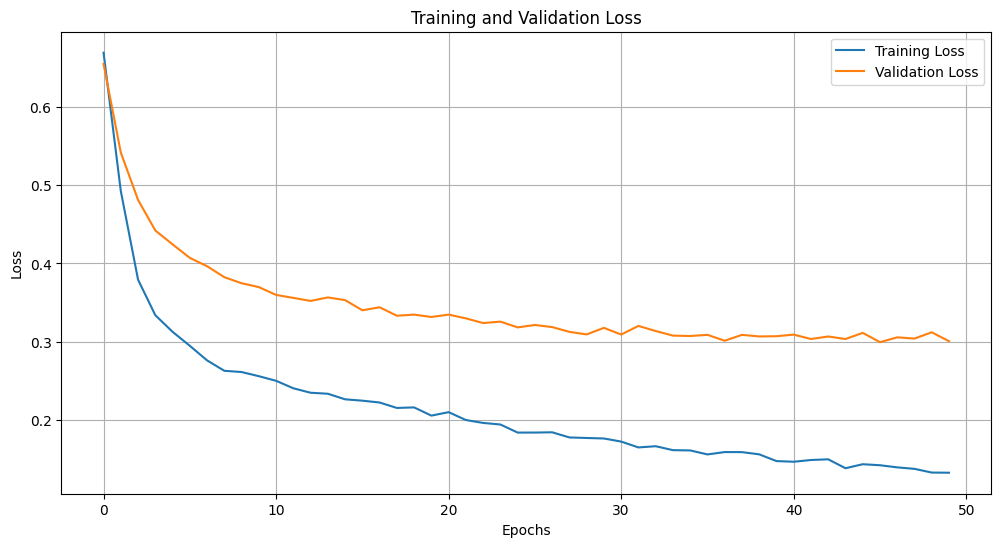

In [ ]:
# Create a figure and set its size.
plt.figure(figsize=(12, 6))

# Plot the training and validation losses.
plt.plot(np.arange(len(training_losses)), training_losses, label='Training Loss')
plt.plot(np.arange(len(validation_losses)), validation_losses, label='Validation Loss')

# Add legend, grid, title, and labels to the plot.
plt.legend()
plt.grid()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xticks(np.arange(0, epochs, 1))

# Show the plot.
plt.show()

## Quantative Analysis.

In [ ]:
def get_recall_precision(edge_index_data, K):
    with torch.no_grad():
        # Get final user and movie embeddings from the model.
        final_user_emb = model.users_emb.weight
        final_movie_emb = model.movies_emb.weight

        # Predictions: calculate ratings for all user-movie pairs.
        rating_val = torch.matmul(final_user_emb, final_movie_emb.T)
        # Get top K predicted movie indices for each user.
        _, indices_pred = torch.topk(rating_val, K)

        # Get unique users in the data.
        unique_users_in_data = edge_index_data[0].unique()

        recalls = []
        precisions = []
        # Iterate over unique users.
        for user in unique_users_in_data:
            user = user.item()
            # Get indices of positive items for the user.
            positive_items_idx = torch.nonzero((edge_index_data[0] == user), as_tuple=True)[0]
            positive_items = edge_index_data[1][positive_items_idx]
            actual_movies = positive_items.tolist()
            predicted_movies = indices_pred[user].tolist()
            if len(actual_movies) == 0:
                continue
            # Calculate recall and precision for the user.
            common_movies = sum([1 for movie in actual_movies if movie in predicted_movies])
            recalls.append(common_movies / len(actual_movies))
            precisions.append(common_movies / K)

    # Calculate average recall and precision across all users.
    recall_k = sum(recalls) / len(recalls)
    precision_k = sum(precisions) / len(precisions)
    return recall_k, precision_k

In [ ]:
# Set the model to evaluation mode.
model.eval()
with torch.no_grad():
    # Calculate test loss using the test data.
    criterion_test = BPRLoss(test_data.shape[1])
    final_user_emb, init_users_emb, final_movies_emb, init_movies_emb = model(sparse_test_data)
    test_loss = criterion_test(test_data, final_user_emb, init_users_emb, final_movies_emb, init_movies_emb)

# Print the test loss.
print(f"Test Loss was : {test_loss.item()}")

# Calculate recall and precision at K=20 and K=50 for train, validation, and test data.
recall20_train, precision20_train = get_recall_precision(train_data, 20)
recall20_val, precision20_val = get_recall_precision(val_data, 20)
recall20_test, precision20_test = get_recall_precision(test_data, 20)
recall50_train, precision50_train = get_recall_precision(train_data, 50)
recall50_val, precision50_val = get_recall_precision(val_data, 50)
recall50_test, precision50_test = get_recall_precision(test_data, 50)

# Print recall and precision at K=20 and K=50 for train, validation, and test data.
print(tabulate([['Recall@20', recall20_train, recall20_val, recall20_test],
                ['Precision@20', precision20_train, precision20_val, precision20_test],
                ['Recall@50', recall50_train, recall50_val, recall50_test],
                ['Precision@50', precision50_train, precision50_val, precision50_test]],
               headers=['Metric', 'Train', 'Val', 'Test'], tablefmt='fancy_grid'))


Test Loss was : 0.27824077010154724
╒══════════════╤══════════╤═══════════╤═══════════╕
│ Metric       │    Train │       Val │      Test │
╞══════════════╪══════════╪═══════════╪═══════════╡
│ Recall@20    │ 0.122715 │ 0.109944  │ 0.105631  │
├──────────────┼──────────┼───────────┼───────────┤
│ Precision@20 │ 0.222085 │ 0.0295455 │ 0.0288288 │
├──────────────┼──────────┼───────────┼───────────┤
│ Recall@50    │ 0.218625 │ 0.20678   │ 0.189869  │
├──────────────┼──────────┼───────────┼───────────┤
│ Precision@50 │ 0.176617 │ 0.0224825 │ 0.0225946 │
╘══════════════╧══════════╧═══════════╧═══════════╛
